# EDA: MIMIC-III ICU Readmissions

In [53]:
import psycopg2
from psycopg2 import extras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [11]:
def cursor_connect(cursor_factory=None):
    """
    Connects to the DB and returns the connection and cursor, ready to use.
    Parameters
    ----------
    cursor_factory : psycopg2.extras
    Returns
    -------
    (psycopg2.extensions.connection, psycopg2.extensions.cursor)
        A tuple of (psycopg2 connection, psycopg2 cursor).
    """
    #DB connection
    conn = psycopg2.connect(dbname="mimic", user="mimic", host="localhost", port="2345",
                            password="oNuemmLeix9Yex7W")
    if not cursor_factory:
        cur = conn.cursor()
    else:
        cur = conn.cursor(cursor_factory=cursor_factory)
    return conn, cur

def exec_query(query, curs_dict=True):
    
    if curs_dict == True: 
        conn, cur = cursor_connect(psycopg2.extras.DictCursor)
    else:
        conn, cur = cursor_connect()
    cur.execute(query)
    rows = cur.fetchall()
    return rows

## Patient Admissions

In [21]:
q_nhadm = """SELECT COUNT(DISTINCT hadm_id) FROM admissions;"""
q_nhadm_patient = """SELECT COUNT(DISTINCT subject_id) FROM admissions;"""
q_nicu = """SELECT COUNT(*) FROM icustays;"""
q_nicu_patient = """SELECT COUNT(DISTINCT subject_id) FROM icustays;"""
q_nicu_readm = """SELECT COUNT(*) FROM 
        (SELECT subject_id, COUNT(icustay_id) AS n_icustays
        FROM icustays
        GROUP BY subject_id) AS sub_q
    WHERE n_icustays > 1;"""

n_hadm = exec_query(q_nhadm)
n_hadm_patient = exec_query(q_nhadm_patient)
n_icustay = exec_query(q_nicu)
n_icu_patient = exec_query(q_nicu_patient)
n_nicu_readm = exec_query(q_nicu_readm)

print "Hospital Admissions:"
print "Number of Unique Hospital Admissions = ", n_hadm[0][0]
print "Number of Unique Patients Admitted = ", n_hadm_patient[0][0]
print "\nICU stays:"
print "Number of Unique ICU stays = ", n_icustay[0][0]
print "Number of Unique Patients with ICU stays = ", n_icu_patient[0][0]
print "Number of Patients with ICU Readmissions", n_nicu_readm[0][0]

Hospital Admissions:
Number of Unique Hospital Admissions =  58976
Number of Unique Patients Admitted =  46520

ICU stays:
Number of Unique ICU stays =  61532
Number of Unique Patients with ICU stays =  46476
Number of Patients with ICU Readmissions 8755


n<sub>hadm</sub> < n<sub>icustay</sub> because a patient may have *multiple ICU stay* within a unique hospital admission.

Majority of patients admitted into the hospital had at least 1 ICU stay (99%), though only 18% were readmitted multiple times (> 1 icu stay).

#### Number of Unique Admissions involving ICU stay

In [152]:
q_icu_hadm = """SELECT COUNT(DISTINCT hadm_id) FROM icustays;"""
exec_query(q_icu_hadm)[0][0]

57786L

#### N<sub>icustays</sub> per Hospital Admission

In [115]:
q_hadm_icu = """SELECT icu.hadm_id, COUNT(icu.icustay_id) AS n_icustay
FROM 
    admissions as adm 
INNER JOIN 
    icustays as icu
ON adm.hadm_id = icu.hadm_id
GROUP BY icu.hadm_id;
"""
n_icu_hadm = exec_query(q_hadm_icu, False)
df_icu_hadm = pd.DataFrame(n_icu_hadm, 
                           columns = ['hadm_id', 'n_icustay'])
print "Max ICU stays per Hospital Adm = %.2f" % df_icu_hadm.n_icustay.max()
print "Average ICU stay per Hospital Adm = %.2f" % df_icu_hadm.n_icustay.mean()

Max ICU stays per Hospital Adm = 7.00
Average ICU stay per Hospital Adm = 1.06


## ICU Stay

### Hospital Admission LOS vs. n<sub>icustay</sub>

In [155]:
q_hadmlos_icu = """SELECT EXTRACT(day FROM (dischtime-admittime)) 
AS adm_los, n_icustays
FROM admissions as a
INNER JOIN
    (SELECT hadm_id, COUNT(*) AS n_icustays FROM icustays 
    GROUP BY hadm_id) AS i
ON a.hadm_id = i.hadm_id;"""
hadmlos_icu = exec_query(q_hadmlos_icu, False)
df_hadmlos_icu = pd.DataFrame(hadmlos_icu, 
                              columns=['adm_los', 'n_icustay'])
df_hadmlos_icu.sort_values('n_icustay', ascending=False)

,adm_los,n_icustay
38139,84.0,7
41524,70.0,7
15792,140.0,6
54253,105.0,6
32359,108.0,6
15700,65.0,5
18718,118.0,5
23867,72.0,5
22346,107.0,5
36797,71.0,5


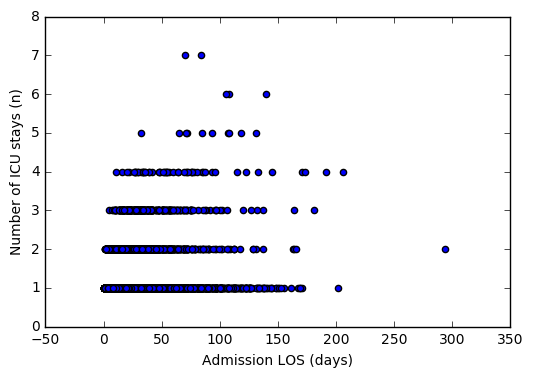

In [158]:
plt.scatter(df_hadmlos_icu.adm_los, df_hadmlos_icu.n_icustay)
plt.xlabel('Admission LOS (days)')
plt.ylabel('Number of ICU stays (n)')
plt.show()

There appears to be no clear correlation between the length of each hospital admission and the number of ICU stays.

### Length of Stay (LOS)

In [107]:
iculos = exec_query("""SELECT los FROM icustays;""")
# Query output
iculos_arr = np.array(iculos)[:,0].astype(np.float)
iculos_arr = np.rint(iculos_arr)
iculos_df = pd.Series(iculos_arr).dropna()

print "ICU LOS Mean = %.2f days" % iculos_df.mean()
print "ICU LOS Median = %.2f days" % iculos_df.median()

ICU LOS Mean = 4.91 days
ICU LOS Median = 2.00 days


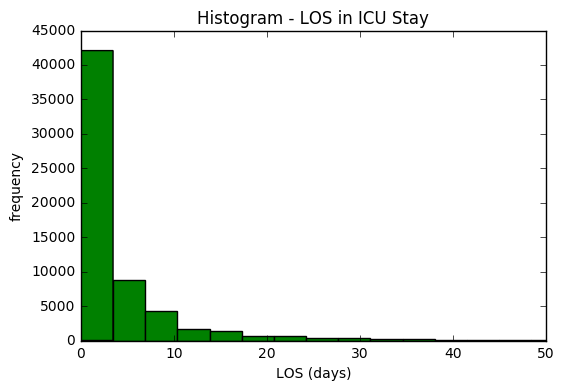

In [104]:
iculos = exec_query("""SELECT los FROM icustays;""")

iculos_arr = np.array(iculos)[:,0].astype(np.float)
iculos_arr = np.rint(iculos_arr)
iculos_df = pd.Series(iculos_arr).dropna()
plt.hist(iculos_df, color='g', bins=50)
plt.xlabel('LOS (days)')
plt.ylabel('frequency')
plt.xlim([0,50])
plt.title('Histogram - LOS in ICU Stay')
plt.show()

`LOS` in the ICU has a *right-skewed* distribution, where the right tail is longer. Thus, indicating that the mean (4.91 days) > median (2.00 days).

### Frequency of Admitted First Care Units

In [129]:
q_firstcu = """SELECT first_careunit, COUNT(*) AS n_careunit FROM icustays 
GROUP BY first_careunit;"""
first_cu = exec_query(q_firstcu, False)
df_fcu = pd.DataFrame(first_cu, columns=['first_cu', 'n_patient'])
df_fcu.sort_values('n_patient', ascending=False)       

,first_cu,n_patient
0,MICU,21088
3,CSRU,9855
1,SICU,8891
4,NICU,8100
5,CCU,7726
2,TSICU,5872


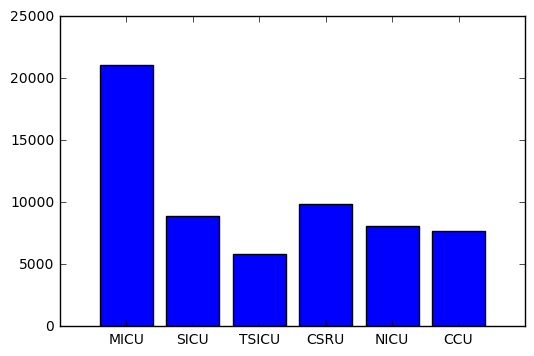

In [126]:
plt.bar(range(6), df_fcu.n_patient, align='center')
plt.ylabel('Frequency (n_patients)')
plt.xticks(range(6), df_fcu.first_cu)
plt.show()

`MICU` (Mobile ICU), such as specialized ambulance care, are by the far the most frequently ICU type used for the patients' first admission into the ICU. 

**Ranking**:
  1. Mobile Intensive Care Unit (`MICU`)
  2. Cardiac Surgery Recovery Unit (`CSRU`)
  3. Surgical Intensive Care Unit (`SICU`)
  4. Neonatal Intensive Care Unit (`NICU`)
  5. Cardiac Care Unit (`CCU`)
  6. Trauma Surgical Intensive Care Unit (`TSICU`)


## ICU Readmissions

#### Identify Patients that have been readmitted into the ICU
Each unique patient & their corresponding number of icustays.

In [130]:
q_icupat="""SELECT * FROM
    (SELECT subject_id, COUNT(icustay_id) AS n_icustays
    FROM icustays
    GROUP BY subject_id) AS sub_q
WHERE n_icustays > 1;"""

icu_pat = exec_query(q_icupat, False)
df_icu_pat = pd.DataFrame(icu_pat, columns=['patientid', 'n_icustay'])
df_icu_pat

,patientid,n_icustay
0,7,2
1,17,2
2,21,2
3,23,2
4,34,2
5,36,3
6,41,2
7,61,2
8,67,2
9,68,3


In [32]:
df_icu_pat.n_icustay.mean()

2.7197030268418048

Mean of n_icustay for readmitted patients is 2.72 stays.

In [35]:
df_icu_pat.n_icustay.std()

1.6929665150814004

Standard deviation of readmitted is 1.69. Thus, we can expect the number of icu stays for a patient to deviate about 1-2 stays from the average (2.72 stays).

In [34]:
df_icu_pat.n_icustay.max()

41

Max number of readmitted ICU stays by a patient is 41.

In [33]:
df_icu_pat.n_icustay.value_counts()

2     5796
3     1619
4      650
5      300
6      151
7       86
8       44
9       29
10      19
11      15
12      11
13       8
15       6
14       4
16       2
17       2
25       2
21       2
18       2
41       1
38       1
35       1
23       1
20       1
22       1
31       1
Name: n_icustay, dtype: int64

### Ethnicity

In [151]:
q_ethn_icu = """SELECT ethnicity, SUM(n_icustays)
FROM 
    (SELECT subject_id, hadm_id, ethnicity FROM admissions) AS a
INNER JOIN 
    (SELECT subject_id AS icu_sid, COUNT(icustay_id) AS n_icustays
    FROM icustays GROUP BY subject_id) AS i
ON a.subject_id = i.icu_sid
WHERE n_icustays > 1
GROUP BY ethnicity;"""
ethn_icu = exec_query(q_ethn_icu, False)
df_ethn_icu = pd.DataFrame(ethn_icu, 
                           columns = ['ethnicity', 'total_readm'])
df_ethn_icu.sort_values('total_readm', ascending=False)

,ethnicity,total_readm
27,WHITE,50669
4,BLACK/AFRICAN AMERICAN,17526
9,HISPANIC OR LATINO,2008
2,UNKNOWN/NOT SPECIFIED,1947
17,OTHER,1417
11,ASIAN,875
33,HISPANIC/LATINO - PUERTO RICAN,706
12,PATIENT DECLINED TO ANSWER,303
20,ASIAN - ASIAN INDIAN,288
21,WHITE - RUSSIAN,269


Patients of white and african american ethnicities appear to be more prone to readmission into the ICU (multiple ICU stays).

## Potential Exclusions
### 1. Patients with Negative LOS 
Potential organ donors

In [134]:
q_neglos = """SELECT subject_id, los FROM
    (SELECT *, EXTRACT(minute FROM (dischtime-admittime)) AS los
    FROM admissions) AS sub_q
WHERE LOS < 0;"""
neglos = exec_query(q_neglos, False)
df_neglos = pd.DataFrame(neglos, columns=['patient_id', 'los'])
df_neglos.head()

,patient_id,los
0,417,-57.0
1,181,-20.0
2,516,-8.0
3,1334,-43.0
4,1381,-25.0


In [136]:
df_neglos.shape

(98, 2)

98 patients that have a negative length of stay.

### 2. Age Typo
Unrealistic/unlikely age.

In [142]:
q_ageerr = """SELECT subject_id, age FROM
    (SELECT *, FLOOR((dod::date -  dob::date)/365.0) AS age 
    FROM patients WHERE dod is not null) AS sub_q
WHERE age > 120;
"""
age_err = exec_query(q_ageerr, False)
df_ageerr = pd.DataFrame(age_err, columns=['patient_id', 'age'])
df_ageerr

,patient_id,age
0,19,301
1,34,305
2,56,300
3,112,302
4,149,300
5,151,303
6,166,300
7,175,300
8,213,300
9,304,300


### 3. Missing Previous Care Unit 
Prior to transfer to another Care Unit or from the normal ward.

In [145]:
q_prevcu = """SELECT prev_careunit, count(*) 
FROM transfers GROUP BY prev_careunit;"""
prevcu = exec_query(q_prevcu, False)
df_prevcu = pd.DataFrame(prevcu, columns=['unit', 'n_transf'])
df_prevcu.sort_values('n_transf', ascending=False)

,unit,n_transf
3,,165888
0,MICU,26398
6,NICU,18631
4,CSRU,14322
2,SICU,11321
7,CCU,9534
1,NWARD,8297
5,TSICU,7506
